Имея решение `1d`  задачи для двух жидкостей, можем получить `2d` решение

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import utils as u
import scipy
import pandas as pd

from IPython import display

In [71]:
# import torch
# import ctypes
# ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

In [72]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# device

In [73]:
def two_dim_index_to_one(i: int, j: int, ny: int) -> int:
    return ny * i + j
def one_d_index_to_two(one_d: int, ny: int):
    i = int(one_d / ny)
    j = one_d % ny
    return i, j

In [74]:
nx = 25
ny = 25
k = 1e-1 * 1.987e-13  # 1 darcy to m^2
dx = 3 # m
dy = 3 # m
phi = 0.4
p_0 = 150 * 10 ** 5  # psi to Pa
d = 10  # m
dt = 120  # s
s_0 = 0.3
s_b = 0.1
p = np.ones((nx*ny, 1)) * p_0
s_o = np.ones((nx*ny, 1)) * s_0
s_w = np.ones((nx*ny, 1))* (1 - s_0)

Перейдём к сжимаемости для [rock](https://www.sciencedirect.com/topics/engineering/formation-compressibility), [water and oil](http://www.fekete.com/san/webhelp/feketeharmony/harmony_webhelp/content/html_files/reference_material/general_concepts/reservoir_properties.htm)

In [75]:
c_w = 1e-6 # # Pa^-1
c_o = 1e-6 # # Pa^-1
c_r = 3e-6 #  Pa^-1 

Также различаются вязкости [oil](https://petrowiki.org/Oil_viscosity) и [water](http://fekete.com/SAN/TheoryAndEquations/HarmonyTheoryEquations/Content/HTML_Files/Reference_Material/General_Concepts/Reservoir_Fluid_Properties.htm)

In [76]:
B_o = 1
B_w = 1
mu_o = 15 / 1000 # cp to Pa * s
mu_w = 1 / 1000 # cp to Pa * s

Такс, вводим гиперпараметры для относитльной проницаемости

In [77]:
l_w = 2.
l_o = 2.
s_wir = 0.2
s_wor = 0.8
k_rwr = 0.1
k_rot = 1.
e_w = 1.
e_o = 1.
t_w = 2.
t_o = 2.

Запихнём всю эту информацию в специальный класс

In [78]:
import res_properties
import imp
imp.reload(res_properties)

<module 'res_properties' from 'C:\\Users\\PC\\Documents\\SLB\\01_Reservoir_model_master\\now_do_simple_models\\res_properties.py'>

In [79]:
prop = res_properties.Properties(nx=nx, ny=ny, k=k, dx=dx, dy=dy, phi=phi, p_0=p_0, d=d, dt=dt, s_0=s_0,
                 c_w=c_w, c_o=c_w, c_r=c_r, mu_w=mu_w, mu_o=mu_o, b_o=B_o, b_w=B_w, l_w=l_w, l_o=l_o,
                 s_wir=s_wir, s_wor=s_wor, k_rwr=k_rwr, k_rot=k_rot, e_w=e_w, e_o=e_o, t_w=t_w, t_o=t_o)

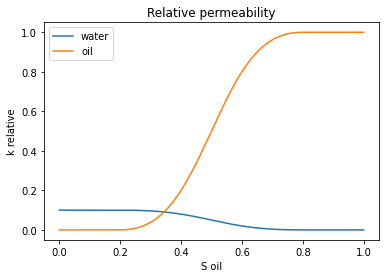

In [80]:
ss = np.linspace(0, 1, 200)
k_rels_w = [prop.k_rel_w(1-s) for s in ss]
k_rels_o = [prop.k_rel_o(s) for s in ss]
plt.plot(ss, k_rels_w, label='water')
plt.plot(ss, k_rels_o, label='oil')
plt.xlabel('S oil')
plt.ylabel("k relative")
plt.title('Relative permeability')
plt.legend()
plt.show()

In [81]:
from reservoir import ResState

In [82]:
p = ResState(p, p_0, prop)
s_o = ResState(s_o, s_b, prop)
s_w = ResState(s_w, 1 - s_b, prop)

Дальше немного сложенее - теперь нужно вводить межблочную относительную проницаемость

Небольшие изменения потерпит матарица, отвечающая за лапласиан

In [83]:
from reservoir import get_lapl_one_ph_np as get_lapl_one_ph

In [84]:
lapl_w = np.zeros((prop.nx * prop.ny, prop.nx * prop.ny))
lapl_o = np.zeros((prop.nx * prop.ny, prop.nx * prop.ny))

In [85]:
from reservoir import get_q_bound

In [86]:
q_bound_w = np.zeros((prop.nx * prop.ny, 1))
q_bound_o = np.zeros((prop.nx * prop.ny, 1))

Теперь про моделирование скважины

Закинем координаты скважин

In [87]:
pos_r = {(12, 8): 0.1, (18, 21): 0.1}
delta_p_well = -100 * 6894.
delta_p_vec = np.ones((nx*ny, 1)) * delta_p_well

In [88]:
from reservoir import get_j_matrix

In [89]:
j_o = np.zeros((prop.nx * prop.ny, 1))
j_w = np.zeros((prop.nx * prop.ny, 1))
_ = get_j_matrix(s=s_o, p=p, pos_r=pos_r, ph='o', prop=prop, j_matr=j_o)
_ = get_j_matrix(s=s_w, p=p, pos_r=pos_r, ph='w', prop=prop, j_matr=j_w)

И последний штрих - перед производной по времени есть $V_b\big(S_o c_o + S_w c_w  +1\cdot c_r\big)$. Назовём это `dt_comp_sat`

Кстати, у нас теперь `2d` и теперь нужно делать `.reshape`

In [90]:
dt_comp_sat = dx * dy * d *(s_o.v * c_o + s_w.v * c_w + np.ones((nx*ny, 1)) * c_r)

In [91]:
nxny_ones = np.ones((nx*ny, 1))
nxny_eye = np.eye(nx*ny) 

Закаидываем пареметры для запуска сессии и записи истории

In [92]:
n_iter = int(5e1)
p_ex = np.ones((nx, 1)) * p_0
t = 0
xs = list((np.linspace(0, nx-1, nx) + dx/2) * dx)
plot_freq = int(1e5)
times = []
p_well_hist = {}
s_o_well_hist = {}
q_o_hist = {}
q_w_hist = {}
for w in pos_r:
    p_well_hist[w] = []
    s_o_well_hist[w] = []
    q_o_hist[w] = []
    q_w_hist[w] = []

In [93]:
from reservoir import Env

In [94]:
%%time
for i in tqdm(range(n_iter)):
    # gonna increase time step
    # matrixes depends on saturation
    dt_comp_sat = (dx * dy * d *s_o.v * c_o + dx * dy * d * s_w.v * c_w + np.ones((nx*ny, 1)) * c_r)
    _ = get_j_matrix(s=s_o, p=p, pos_r=pos_r, ph='o', prop=prop, j_matr=j_o)
    _ = get_j_matrix(s=s_w, p=p, pos_r=pos_r, ph='w', prop=prop, j_matr=j_w)
    lapl_w, si_w = get_lapl_one_ph(p=p, s=s_w, ph='w', prop=prop)
    lapl_o, si_o = get_lapl_one_ph(p=p, s=s_o, ph='o', prop=prop)
    _ = get_q_bound(p, s_w, 'w', prop, q_b=q_bound_w)
    _ = get_q_bound(p, s_o, 'o', prop, q_b=q_bound_o)
    prop.dt = 0.1 * 0.5 * phi * dt_comp_sat.min() / (si_o + si_w)
    # matrix for implicit pressure
    a = phi * np.eye(nx*ny) * dt_comp_sat - (lapl_w + lapl_o) * prop.dt
    #right hand state for ax = b
    
    b = phi * dt_comp_sat * p.v + q_bound_w*prop.dt + q_bound_o*prop.dt 
    b += (j_o * B_o + j_w * B_w) * delta_p_vec * prop.dt
    # upd time stamp
    t += prop.dt / (60. * 60 * 24)
    # solve p
    p_new = np.linalg.solve(a, b)
    dp = p_new - p.v
    
    a = dx*dy*d * phi *(np.ones((nx * ny, 1)) + (c_r + c_o) * (p_new - p.v))
    
    b = phi * dx*dy*d * s_o.v + prop.dt * (lapl_o.dot(p_new) + q_bound_o + j_o * B_o * delta_p_vec)
    # upd target values
    s_o = ResState((b / a), s_b, prop) 
    s_w = ResState(np.ones((nx*ny, 1)) - s_o.v, 1 - s_b, prop) 
    p = ResState(p_new, p_0, prop)
    if i % plot_freq == -1:
        
        q_o = ((-1) * j_o * (delta_p_vec)).reshape((nx, ny))
        q_w = ((-1) * j_w * (delta_p_vec)).reshape((nx, ny))
        
        # gonna set wells as nan to see gradient
        # p_v_disp = p.v.reshape((nx, ny)).copy() / 6894.
        # s_o_disp = s_o.v.reshape((nx, ny)).copy()
        
        times.append(t)
        for w in pos_r:
            p_well_hist[w].append(p[w] / 6894.)
            s_o_well_hist[w].append(s_o[w])
            q_o_hist[w].append(q_o[w])
            q_w_hist[w].append(q_w[w])
            # set wells as nan to see gradient
            # p_v_disp[w] = np.nan
            # s_o_disp[w] = np.nan
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
        f.tight_layout(pad=6.0)
        
        sns.heatmap(p.v.reshape((nx, ny)) / 6894., ax=ax[0][0], cbar=True)
        ax[0][0].set_title(f'Pressure, psi\nt={t: .1f} days \n nan at well pos')
        
        sns.heatmap(s_o.v.reshape((nx, ny)), ax=ax[0][1], cbar=True, fmt=".2f")
        ax[0][1].set_title(f'Saturation, oil, psi\nt={t: .1f} days\n nan at well pos')
        
        for w in pos_r:
            ax[1][0].plot(times, p_well_hist[w] , label=f'{w}')
            ax[1][1].plot(times, s_o_well_hist[w] , label=f'{w}')
            ax[2][0].plot(times, q_o_hist[w] , label=f'{w}')
            ax[2][1].plot(times, q_w_hist[w] , label=f'{w}')
        ax[1][0].set_xlabel('time, days')
        ax[1][0].set_ylabel('pressure, psi')
        ax[1][0].set_title('Pressure in wells')
        ax[1][0].legend()
        
        ax[1][1].set_xlabel('time, days')
        ax[1][1].set_ylabel('saturation')
        ax[1][1].set_title('Oil saturation in wells')
        ax[1][1].legend()
        
        ax[2][0].set_xlabel('time, days')
        ax[2][0].set_ylabel('q, m3/s')
        ax[2][0].set_title('Oil rate')
        ax[2][0].legend()
        
        ax[2][1].set_xlabel('time, days')
        ax[2][1].set_ylabel('q, m3/s')
        ax[2][1].set_title('Water rate')
        ax[2][1].legend()
                
        plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.18it/s]

Wall time: 1.19 s


In [95]:
for i in tqdm(range(1, 100)):
    dt_comp_sat = (dx * dy * d *(s_o.v) * c_o + s_w.v * c_w + nxny_ones * c_r)
    _ = get_j_matrix(p=p, s=s_o, pos_r=pos_r, ph='o', prop=prop, j_matr=j_o)
    _ = get_j_matrix(p=p, s=s_w, pos_r=pos_r, ph='w', prop=prop, j_matr=j_o)

100%|███████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 24751.79it/s]


In [102]:
%%timeit
l_w = get_lapl_one_ph(p=p, s=s_w, ph='w', prop=prop)
# l_o = get_lapl_one_ph(p=p, s=s_o, ph='o', prop=prop)

3.87 ms ± 3.26 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
s = s_o
ph = 'o'

С заполнением списка - 103

Без - 400

In [99]:
s = s_o
ph = 'o'

In [104]:
%%timeit 
s_b_test_x = np.ones((prop.nx, 1)) * s.bound_v
p_b_test_x = np.ones((prop.nx, 1)) * p.bound_v

s_x_ext = np.append(s.v.reshape((prop.nx, prop.ny)), s_b_test_x, axis=1)
s_x_ext = s_x_ext.reshape(-1)
s_x_ext = np.insert(s_x_ext, 0, s.bound_v)

p_x_ext = np.append(p.v.reshape((prop.nx, prop.ny)), p_b_test_x, axis=1)
p_x_ext = p_x_ext.reshape(-1)
p_x_ext = np.insert(p_x_ext, 0, p.bound_v)

out_x = np.zeros(prop.nx * (prop.ny + 1))
for i in range(len(p_x_ext) - 1):
    if p_x_ext[i] >= p_x_ext[i + 1]:
        out_x[i] = s_x_ext[i]
    else:
        out_x[i] = s_x_ext[i + 1]
k_rel_x = prop.k_rel_ph_1val_np(out_x, ph)
sigma = k_rel_x.max()
    ##############################################
s_b_test_y = np.ones((1, prop.ny)) * s_b_test_x[0]
p_b_test_y = np.ones((1, prop.ny)) * p_b_test_x[0]

s_y_ext = np.append(s.v.reshape((prop.nx, prop.ny)), s_b_test_y, axis=0)
s_y_ext = s_y_ext.T.reshape(-1)
s_y_ext = np.insert(s_y_ext, 0, s.bound_v)

p_y_ext = np.append(p.v.reshape((prop.nx, prop.ny)), p_b_test_y, axis=0)
p_y_ext = p_y_ext.T.reshape(-1)
p_y_ext = np.insert(p_y_ext, 0, p.bound_v)

out_y = np.zeros((prop.nx + 1) * prop.ny)

for i in range(len(p_y_ext) - 1):
    if p_y_ext[i] >= p_y_ext[i + 1]:
        out_y[i] = s_y_ext[i]
    elif p_y_ext[i] <= p_y_ext[i + 1]:
        out_y[i] = s_y_ext[i + 1]
    
k_rel_y = prop.k_rel_ph_1val_np(out_y, ph)
sigma = min(sigma, k_rel_y.max())
# k_rel_w_y = [f(1 - s_o) for s_o in out_y] # consuming

# let's go diagonals
# main is first
# for x we need to drop first and last col
main_dia = np.zeros(prop.nx * prop.ny)
main_dia += np.delete(k_rel_x.reshape((prop.nx, prop.ny + 1)), obj=-1, axis=1).reshape(-1)
main_dia += np.delete(k_rel_x.reshape((prop.nx, prop.ny + 1)), obj=0, axis=1).reshape(-1)

main_dia += np.delete(k_rel_y.reshape((prop.ny, prop.nx + 1)), obj=-1, axis=1).T.reshape(-1)
main_dia += np.delete(k_rel_y.reshape((prop.ny, prop.nx + 1)), obj=0, axis=1).T.reshape(-1)

close_dia = k_rel_x.reshape((prop.nx, prop.ny + 1))
close_dia = np.delete(close_dia, obj=-1, axis=1)
close_dia = close_dia.reshape(-1)
close_dia *= prop.mask_close

dist_dia = k_rel_y.reshape((prop.ny, prop.nx + 1))
dist_dia = np.delete(dist_dia, obj=-1, axis=1)
dist_dia = np.delete(dist_dia, obj=0, axis=1)
dist_dia = dist_dia.T.reshape(-1)

lapl = scipy.sparse.diags(diagonals=[dist_dia, close_dia[1:],
                                     -1 * main_dia,
                                     close_dia[1:], dist_dia
                                    ],
                          offsets=[-1 * prop.ny, -1, 0, 1, prop.ny])  # .toarray()
lapl *= prop.k * prop.d * prop.dy / prop.mu[ph] / prop.dx
sigma *= prop.k * prop.d * prop.dy / prop.mu[ph] / prop.dx

971 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [105]:
%%timeit 
s_b_test_x = np.ones((prop.nx, 1)) * s.bound_v
p_b_test_x = np.ones((prop.nx, 1)) * p.bound_v

s_x_ext = np.append(s.v.reshape((prop.nx, prop.ny)), s_b_test_x, axis=1)
s_x_ext = s_x_ext.reshape(-1)
s_x_ext = np.insert(s_x_ext, 0, s.bound_v)

p_x_ext = np.append(p.v.reshape((prop.nx, prop.ny)), p_b_test_x, axis=1)
p_x_ext = p_x_ext.reshape(-1)
p_x_ext = np.insert(p_x_ext, 0, p.bound_v)

out_x = np.zeros(prop.nx * (prop.ny + 1))
for i in range(len(p_x_ext) - 1):
    if p_x_ext[i] >= p_x_ext[i + 1]:
        out_x[i] = s_x_ext[i]
    else:
        out_x[i] = s_x_ext[i + 1]
k_rel_x = prop.k_rel_ph_1val_np(out_x, ph)
sigma = k_rel_x.max()
    ##############################################
s_b_test_y = np.ones((1, prop.ny)) * s_b_test_x[0]
p_b_test_y = np.ones((1, prop.ny)) * p_b_test_x[0]

s_y_ext = np.append(s.v.reshape((prop.nx, prop.ny)), s_b_test_y, axis=0)
s_y_ext = s_y_ext.T.reshape(-1)
s_y_ext = np.insert(s_y_ext, 0, s.bound_v)

p_y_ext = np.append(p.v.reshape((prop.nx, prop.ny)), p_b_test_y, axis=0)
p_y_ext = p_y_ext.T.reshape(-1)
p_y_ext = np.insert(p_y_ext, 0, p.bound_v)

out_y = np.zeros((prop.nx + 1) * prop.ny)

for i in range(len(p_y_ext) - 1):
    if p_y_ext[i] >= p_y_ext[i + 1]:
        out_y[i] = s_y_ext[i]
    elif p_y_ext[i] <= p_y_ext[i + 1]:
        out_y[i] = s_y_ext[i + 1]
    
k_rel_y = prop.k_rel_ph_1val_np(out_y, ph)
sigma = min(sigma, k_rel_y.max())
# k_rel_w_y = [f(1 - s_o) for s_o in out_y] # consuming

# let's go diagonals
# main is first
# for x we need to drop first and last col
main_dia = np.zeros(prop.nx * prop.ny)
main_dia += np.delete(k_rel_x.reshape((prop.nx, prop.ny + 1)), obj=-1, axis=1).reshape(-1)
main_dia += np.delete(k_rel_x.reshape((prop.nx, prop.ny + 1)), obj=0, axis=1).reshape(-1)

main_dia += np.delete(k_rel_y.reshape((prop.ny, prop.nx + 1)), obj=-1, axis=1).T.reshape(-1)
main_dia += np.delete(k_rel_y.reshape((prop.ny, prop.nx + 1)), obj=0, axis=1).T.reshape(-1)

close_dia = k_rel_x.reshape((prop.nx, prop.ny + 1))
close_dia = np.delete(close_dia, obj=-1, axis=1)
close_dia = close_dia.reshape(-1)
close_dia *= prop.mask_close

dist_dia = k_rel_y.reshape((prop.ny, prop.nx + 1))
dist_dia = np.delete(dist_dia, obj=-1, axis=1)
dist_dia = np.delete(dist_dia, obj=0, axis=1)
dist_dia = dist_dia.T.reshape(-1)
    
lapl = scipy.sparse.diags(diagonals=[dist_dia, close_dia[1:],
                                     -1 * main_dia,
                                     close_dia[1:], dist_dia
                                    ],
                          offsets=[-1 * prop.ny, -1, 0, 1, prop.ny])  # .toarray()
lapl *= prop.k * prop.d * prop.dy / prop.mu[ph] / prop.dx
sigma *= prop.k * prop.d * prop.dy / prop.mu[ph] / prop.dx

821 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [108]:
%%timeit
for i in range(len(p_y_ext) - 1):
    if p_y_ext[i] >= p_y_ext[i + 1]:
        out_y[i] = s_y_ext[i]
    elif p_y_ext[i] <= p_y_ext[i + 1]:
        out_y[i] = s_y_ext[i + 1]

359 µs ± 950 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
sat_a = np.linspace(0, 1, 100)

In [32]:
def get_s_wn_ph_np(prop, sat_arr):
    out = sat_arr - prop.s_wir
    out /= (prop.s_wor - prop.s_wir)
    out = np.where(out >= 0, out, 0)
    out = np.where(out < 1, out, 1)    
    return out

In [51]:
def k_rel_w_np(prop, sat_arr):
    s_wn = get_s_wn_ph_np(prop, sat_arr)
    out = s_wn ** prop.l_w * prop.k_rwr
    out /= s_wn ** prop.l_w + prop.e_w * (1 - s_wn) ** prop.t_w
    return out

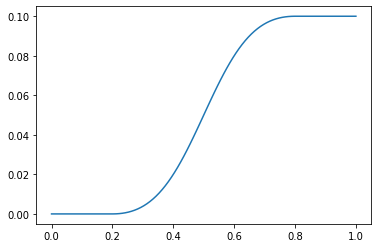

In [52]:
plt.plot(sat_a, k_rel_w_np(prop, sat_a))

In [53]:
def k_rel_o_np(prop, s_o):
    s_w = 1 - s_o
    s_wn = get_s_wn_ph_np(prop, s_w)
    out = prop.k_rot * (1 - s_wn) ** prop.l_o
    out /= (1 - s_wn) ** prop.l_o + prop.e_o * s_wn ** prop.t_o
    return out

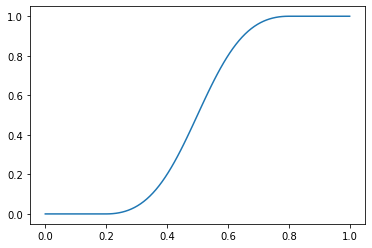

In [54]:
plt.plot(sat_a, k_rel_o_np(prop, sat_a))

In [68]:
def k_rel_ph_1val_np(prop, s_arr, ph):
    out = None
    if ph == 'o':
        out = k_rel_o_np(prop, s_arr)
    elif ph == 'w':
        out = k_rel_w_np(prop, s_arr)
    return out

In [60]:
ph = 'o'

In [61]:
%%timeit
k_rel_y = np.array([prop.k_rel_ph_1val(s_o, ph) for s_o in np.random.rand(25 * 25)])  # consuming
k_rel_y = np.array([prop.k_rel_ph_1val(s_o, ph) for s_o in np.random.rand(25 * 25)])  # consuming

2.86 ms ± 8.54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
%%timeit
k_rel_y = k_rel_ph_1val_np(prop, np.random.rand(25 * 25), ph)  # consuming
k_rel_y = k_rel_ph_1val_np(prop, np.random.rand(25 * 25), ph)  # consuming

58.5 µs ± 94.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
from multiprocessing import Pool
from functools import partial

In [32]:
k_rel_fix_ph = partial(prop.k_rel_ph_1val, ph=ph)

In [33]:
%%timeit
p = Pool(6)
pool_res = p.map_async(k_rel_fix_ph, np.random.rand(int(1e5)))
pool_res.wait()
a = pool_res.get()

1.44 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit
p = Pool(3)
pool_res = p.map_async(k_rel_fix_ph, np.random.rand(int(1e5)))
pool_res.wait()
a = pool_res.get()

1.07 s ± 45.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
for i in tqdm(range(1, 100)):
    dt_comp_sat = (dx * dy * d *(s_o.v) * c_o + s_w.v * c_w + nxny_ones * c_r)
    _ = get_q_bound(p, s_w, 'w', prop, q_b=q_bound_w)
    _ = get_q_bound(p, s_o, 'o', prop, q_b=q_bound_w)

In [ ]:
a = phi * scipy.sparse.diags(diagonals=[dt_comp_sat.reshape(-1)],
                              offsets=[0])
a = a - (l_o[0] + l_w[0]) * dt
b = phi * dt_comp_sat * p.v + q_bound_w*dt + q_bound_o*dt 
b += (j_o * B_o + j_w * B_w) * delta_p_vec * dt
for i in tqdm(range(1, 1000)):
    p_new = scipy.sparse.linalg.spsolve(a, b)

In [ ]:
p_new.shape

In [ ]:
a = phi * scipy.sparse.diags(diagonals=[dt_comp_sat.reshape(-1)],
                              offsets=[0])


In [ ]:
type(l_w[0])

In [ ]:
type(a + l_w[0])

In [ ]:
lapl_o.dot(p_new)

In [ ]:
for i in tqdm(range(1, 1000)):
    a = dx*dy*d * phi *(nxny_ones + (c_r + c_o) * (p_new - p.v))
    b = phi * dx*dy*d * s_o.v + dt * (lapl_o.dot(p_new) + q_bound_o + j_o * B_o * delta_p_vec)

In [ ]:
a = dx*dy*d * phi *(nxny_ones + (c_r + c_o) * (p_new - p.v))
b = phi * dx*dy*d * s_o.v + dt * (lapl_o.dot(p_new) + q_bound_o + j_o * B_o * delta_p_vec)
for i in tqdm(range(1, 1000)):
    s_o = ResState((b / a), s_b, prop) 
    s_w = ResState(nxny_ones - s_o.v, 1 - s_b, prop) 
    p = ResState(p_new, p_0, prop)